In [12]:
import io
import base64
import numpy as np
import time
import SimpleITK as sitk
import sys
import json

import imageio
import nibabel as nib
import matplotlib.pyplot as plt
import cv2



In [1]:
def my_dice(img1_np,img2_np): 
    # print('image1(roi) dtype', type(img1))
    # print('image2(inference) dtype', type(img2))

    # convert to numpy array
    # img1_np = np.array(img1)
    # img2_np = np.array(img2)

    # img2_bytes = img2_np.tobytes()
    img1_float64 = img1_np.astype('float64')
    intersection = np.logical_and(img1_float64, img2_np)

    # print('image1(roi) converted dtype', type(img1_float64))

    union = np.logical_or(img1_float64, img2_np) 
    dice = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection)) 
    return dice


In [34]:
def binary_segmentation_from_png(png_path):
    img = cv2.imread(png_path)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    img_mask = cv2.inRange(img_hsv, lower_red, upper_red)

    # Dimensions are slightly off by 1, so I add padding: ValueError: operands could not be broadcast together with shapes (1460,1714) (1459,1713) 
    img_mask_padded = np.pad(img_mask, ((0, 1), (0, 1)), mode='constant', constant_values=0)

    
    return img_mask_padded

nii_path = 'SSA003_OS_Scan4_2.pngred.pngout_0000.nii.gz'
png_path = 'SSA003_OS_Scan4_2_IRIS_a.png'

png_binary_seg = binary_segmentation_from_png(png_path)

nii_img = nib.load(nii_path)

# nii_data = nii_img.get_fdata()
nii_data = nii_img.dataobj

# Rotate NIfTI data 90 degrees to the right, to align with original image cuz for some reason its off
nii_data_rotated = np.rot90(nii_data, k=1, axes=(1, 0))

# Also need to mirror NIfTI data across the y-axis, to align with original image
nii_data_mirrored = np.fliplr(nii_data_rotated)

nii_binary_seg = np.squeeze(nii_data_mirrored)





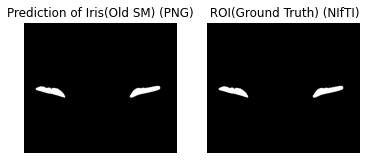

In [39]:
plt.subplot(1, 2, 1)
plt.imshow(png_binary_seg, cmap='gray')
plt.title('Prediction of Iris(Old SM) (PNG)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nii_binary_seg, cmap='gray')
plt.title(' ROI(Ground Truth) (NIfTI)')
plt.axis('off')

plt.show()

In [36]:
dice_score = my_dice(nii_binary_seg, png_binary_seg)

# Print the Dice score
print(f"Dice Score: {dice_score}")

Dice Score: 1.0
